# Raster Resoloution Reprojection
---
Scaling down raster image for either data reduction or alignment with lower resolution raster data sets

This notebook shows how to change the resolution of the pixels inside a raster file (I.E reduce the pixle count, increase the geospatial area represented in a pixle)

## Set up notebook

In [45]:
from osgeo import gdal
import matplotlib.pyplot as plt

## Raster Data Info
---

In [14]:
# Data Load
in_raster = '/workspace/data-sets/Land_Cover/NYC_2017_LiDAR_LandCover.img'
ds = gdal.Open(in_raster)

The projection data tells us the coordinate referance system (CRS) the image is projecte onto. It is critical that all datasets are projected to the same CRS prior to combination. The CRS is a point reference which maps to physical geospatial areas. Different mappings may map pixles to different point on earth, resulting in a nonsensical dataset.

In [11]:
# Get the projection information for the raster
ds_proj = ds.GetProjection()
ds_proj

'PROJCS["NAD83 New York State Planes, Long Island, US Foot",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",40.1666666666667],PARAMETER["central_meridian",-74],PARAMETER["standard_parallel_1",41.0333333333333],PARAMETER["standard_parallel_2",40.6666666666667],PARAMETER["false_easting",984250],PARAMETER["false_northing",0],UNIT["us_survey_feet",0.304800609601219],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

In [10]:
# See if there is any metadata associated with the raster file
ds.getMetadata()

AttributeError: 'Dataset' object has no attribute 'getMetadata'

In [6]:
gt = ds.GetGeoTransform()
print('Top left X', gt[0])
print('Top left y', gt[3])
print('West to East (Width) Pixle Res', gt[1], ' feet')
print('North to South (height Pxile Res', gt[5], ' feet')

Top left X 912286.93
Top left y 273618.3
West to East (Width) Pixle Res 0.5  feet
North to South (height Pxile Res -0.5  feet


We need to understand how many data sets (bands) are included inside the raste file. Multiband raster files act as a data cube with the XY coords representing a point map and the z axis reprenting unique data sets. The Z axis is typically used for time to track how a land feature is changing over time (think errosion or deforestation)

In [13]:
# Get the number of bands in the dataset
ds.RasterCount

1

Since there is only one band (dataset) we do not need to loop over the bands and reprojecet each band to the new resolution

In [21]:
# Get the image size
img_width,img_height=ds.RasterXSize,ds.RasterYSize
img_width,img_height

(310844, 314414)

In [7]:
band = ds.GetRasterBand(1)
print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))
band_min = band.GetMinimum()
band_max = band.GetMaximum()
print('band min:', band_min)
print('band max:', band_max)

Band Type=Byte
band min: 1.0
band max: 8.0


In [22]:
band.DataType

1

The return value of 1 indicates the data is 90bit inconsistent integer
https://www.gislite.com/tutorial/k8023

In [34]:
band.GetUnitType()

''

In [36]:
band.GetScale()

## Reprojection Meathod 1: gdal.Warp
---

In [25]:
xres = 2 # the number of feet in the x direction represented in one pixle
yres = 2 # the number of feet in the y direction represented in one pixle
out_name = '/workspace/data-sets/Land_Cover/nyc-lc-2-2.tif' # Output file name

reduc = gdal.Warp(out_name, in_raster, xRes=xres, yRes=yres)

Lets check the output file to confirm alignment with the original file

In [27]:
ts = gdal.Open(out_name)

In [28]:
ts_proj = ts.GetProjection()
ts_proj

'PROJCS["NAD83 New York State Planes, Long Island, US Foot",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",40.1666666666667],PARAMETER["central_meridian",-74],PARAMETER["standard_parallel_1",41.0333333333333],PARAMETER["standard_parallel_2",40.6666666666667],PARAMETER["false_easting",984250],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

In [29]:
ds_proj

'PROJCS["NAD83 New York State Planes, Long Island, US Foot",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",40.1666666666667],PARAMETER["central_meridian",-74],PARAMETER["standard_parallel_1",41.0333333333333],PARAMETER["standard_parallel_2",40.6666666666667],PARAMETER["false_easting",984250],PARAMETER["false_northing",0],UNIT["us_survey_feet",0.304800609601219],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

In [30]:
ts.RasterCount

1

In [31]:
ds.RasterCount

1

In [32]:
img_width,img_height=ts.RasterXSize,ts.RasterYSize
img_width,img_height

(77711, 78604)

In [33]:
img_width,img_height=ds.RasterXSize,ds.RasterYSize
img_width,img_height

(310844, 314414)

In [43]:
print(310844/4)
print(314414/4)

77711.0
78603.5


Since we increased the value of the pixle representation from 6 inches to 2 feet, we expect a 4X reduction in pixle count in both x and y directions. This is confirmed

In [40]:
band = ts.GetRasterBand(1)
band_min = band.GetMinimum()
band_max = band.GetMaximum()
print('band min:', band_min)
print('band max:', band_max)

band min: None
band max: None


In [38]:
band = ds.GetRasterBand(1)
band_min = band.GetMinimum()
band_max = band.GetMaximum()
print('band min:', band_min)
print('band max:', band_max)

band min: 1.0
band max: 8.0


Lets visualize the reduced raster (Requires 64 Gig of Available ram to run)

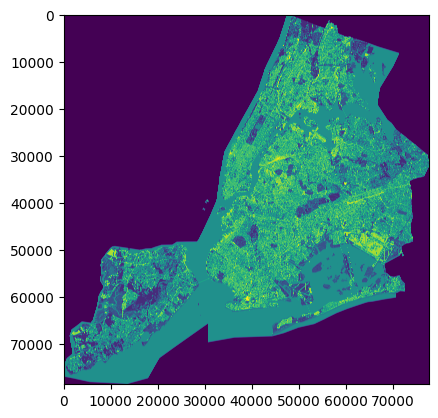

In [46]:
band = ts.GetRasterBand(1)
arr = band.ReadAsArray()
plt.imshow(arr)

##### EOM
---